In [1]:
import os
import json
import pandas as pd
import csv
import datetime
import dateutil.parser
import unicodedata
import time
import configparser
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
import seaborn as sns
from scipy import stats
from scipy.optimize import curve_fit

In [3]:
df = pd.read_csv('processed_housing_data.csv')
display(df.head())
print(df.info())
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percentage_missing': percent_missing})
missing_value_df.sort_values('percentage_missing', inplace=True)
missing_value_df = missing_value_df.reset_index(drop=True)

display(missing_value_df)

date          id  city  district  \
0  2023-03-02  70063685.0     2       112   
1  2023-03-02  20989644.0     3        34   
2  2023-03-02  21125550.0     3       251   
3  2023-03-02     67815.0     3       226   
4  2023-03-02  70063245.0     2       236   

                               address           coordinates  travel_time  \
0  Kivenhakkaajankuja 3 A, 02650 Espoo  60.222933, 24.809138         25.0   
1     Hiihtomäentie 36, 00800 Helsinki  60.203741, 25.032671         24.0   
2     Laivurinkatu 7 A, 00150 Helsinki  60.155891, 24.942462         15.0   
3   Suvilahdenkatu 1 A, 00500 Helsinki  60.186996, 24.966805         16.0   
4         Jousenkaari 9 B, 02120 Espoo  60.175354, 24.788641         29.0   

   condition  new_building     price  ...  rooms  floor  top_floor  balcony  \
0        3.0           0.0  229500.0  ...    2.0    1.0        0.0        1   
1        3.0           0.0  209000.0  ...    1.0    1.0        0.0        0   
2        3.0           0.0  349000.0  ...    2.0    1.0        0.0        0   
3        2.0           0.0  255000.0  ...    2.0    2.0        0.0        1   
4        3.0           0.0  299000.0  ...    2.0    4.0        0.0        1   

   sauna  beach  building_year  apartments_in_building  lvi_upcoming  lvi_past  
0      1      0         1995.0                    63.0             1         1  
1      0      0         1956.0                    26.0             0         0  
2      0      0         1906.0                    22.0             1         1  
3      0      0         1961.0                     NaN             0         0  
4      0      0         1959.0                    84.0             1         1  

[5 rows x 25 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3133 entries, 0 to 3132
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       3133 non-null   object 
 1   id                         2703 non-null   float64
 2   city                       3133 non-null   int64  
 3   district                   3133 non-null   int64  
 4   address                    3133 non-null   object 
 5   coordinates                3133 non-null   object 
 6   travel_time                3133 non-null   float64
 7   condition                  3097 non-null   float64
 8   new_building               3013 non-null   float64
 9   price                      3133 non-null   float64
 10  condominium_fee            3133 non-null   float64
 11  condominium_operation_fee  3133 non-null   float64
 12  condominium_financial_fee  3133 non-null   float64
 13  condominium_land_rent_fee  3133 non-null   float

column_name  percentage_missing
0                        date            0.000000
1                       beach            0.000000
2                       sauna            0.000000
3                     balcony            0.000000
4                   top_floor            0.000000
5                       rooms            0.000000
6                        area            0.000000
7   condominium_land_rent_fee            0.000000
8                lvi_upcoming            0.000000
9   condominium_operation_fee            0.000000
10  condominium_financial_fee            0.000000
11                      price            0.000000
12                travel_time            0.000000
13                coordinates            0.000000
14                    address            0.000000
15                   district            0.000000
16                       city            0.000000
17            condominium_fee            0.000000
18                   lvi_past            0.000000
19                  condition            1.149058
20                      floor            1.244813
21               new_building            3.830195
22              building_year            4.021704
23                         id           13.724864
24     apartments_in_building           18.225343

/var/folders/5q/h1qn2hcn7k7g6khbskw6v9240000gn/T/ipykernel_96475/4101198626.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


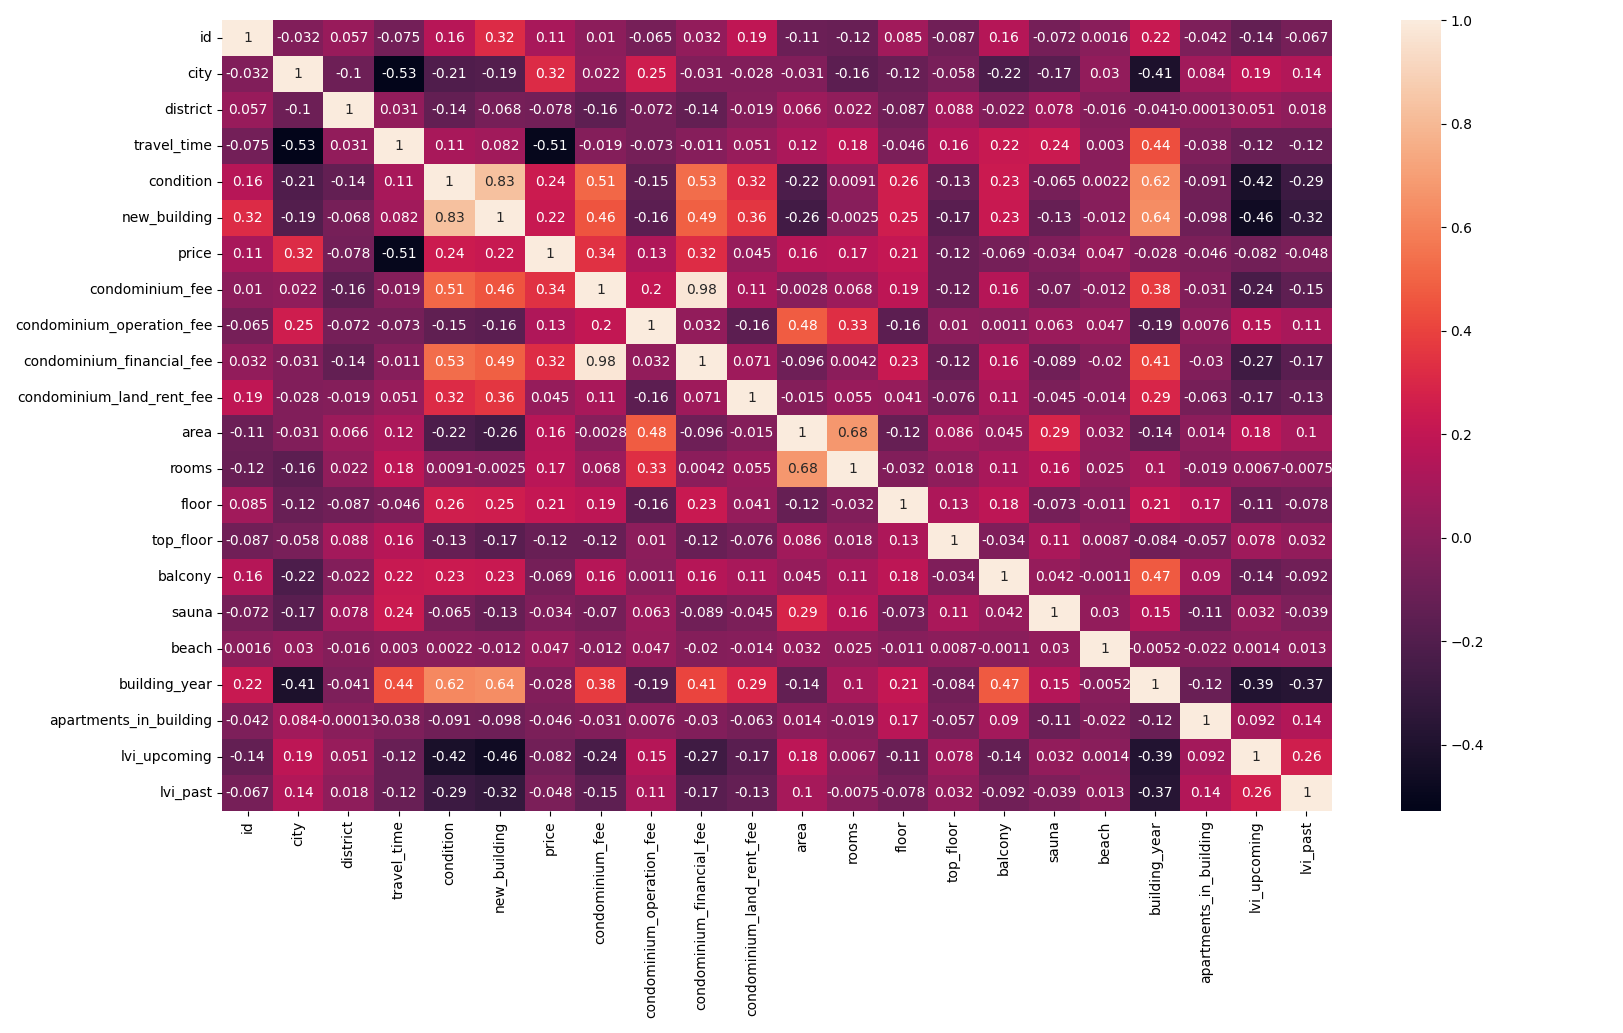

In [205]:
#df_corr = df.loc[df['price'] > 180000]
#df_corr = df.loc[df['price'] < 220000]

correlation_features = ['city', 'travel_time', 'condition', 'new_building', 'condominium_fee', 'condominium_operation_fee', 'condominium_financial_fee', 'area', 'floor', 'top_floor', 'balcony', 'sauna', 'price']

plt.figure('Correlation matrix')
plt.clf()
corr = df.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        annot=True)
plt.tight_layout()
plt.show()

In [6]:
def compute_regression_ci(coefficients:list, x_plot:np.linspace, x:pd.Series, y:pd.Series, pp=0.975) -> np.array:

    n = x.size                  # size of population
    m = coefficients.size       # number of coefficients
    dof = n - m                 # degree of freedom
    z = stats.t.ppf(pp, dof)    # student's t-distribution approximates normal distribution for limited population, and returns z value for given probability

    y_pred = np.polyval(coefficients, x)    # predicts population values using regressions line
    residuals = y - y_pred                  # how much each true value differs from predicted value

    '''
    Toal Variance = Var / Dof -> Standard Deviation = sqrt(Var / Dof)
    '''
    std_error = np.sqrt(np.sum(residuals**2) / dof) # standard deviation of limited population

    '''
    z * std_error:
    z values tels how many standard deviations away from mean an random sample is for given probability.
    Standard deviation of error population defines the amount of movement.

    Std error of constant:
    Var(T) = Var(x1) + Var(x2) + ... + Var(x3) = n*sigma^2
    mean_x = T / n
    SE = Var(mean_x) = Var(T/n) = 1/(n^2) * Var(T) = 1/(n^2) * n*sigma^2 = sigma^2 / n --note: Var(ax) = a^2 Var(x)

    Std error for slope:
    SE = sigma / Var(x) = sigma / sqrt(sum(x - mean_x)^2) --note: SE depends on how spraded the population is
    For a line, SE scales lineary around the mean.
    (x_plot - x_mean) * sigma / sqrt(sum(x - mean_x)^2)

    Total Variance = is a sum of independent variances
    Var = Var_constant + Var_slope
    SE = sigma = Var^2 -> SE = sqrt(Var_constant^2 + Var_slope^2)

    Using math, it is possible to get Std out as constant of the amplitude
    '''
    
    ci = z * std_error * np.sqrt(1/n + (x_plot - np.mean(x))**2 / np.sum((x - np.mean(x))**2))

    '''
    R-squared is a goodness-of-fit measure for linear regression models. 
    This statistic indicates the percentage of the variance in the dependent variable that the independent variables explain collectively.

    r2 = variance explained by the model divided by the total variance
    '''

    numerator = np.sum((x - np.mean(x))*(y - np.mean(y)))
    denominator = ( np.sum((x - np.mean(x))**2) * np.sum((y - np.mean(y))**2) )**.5
    correlation_coef = numerator / denominator
    r2 = correlation_coef**2 * 100

    return ci, r2

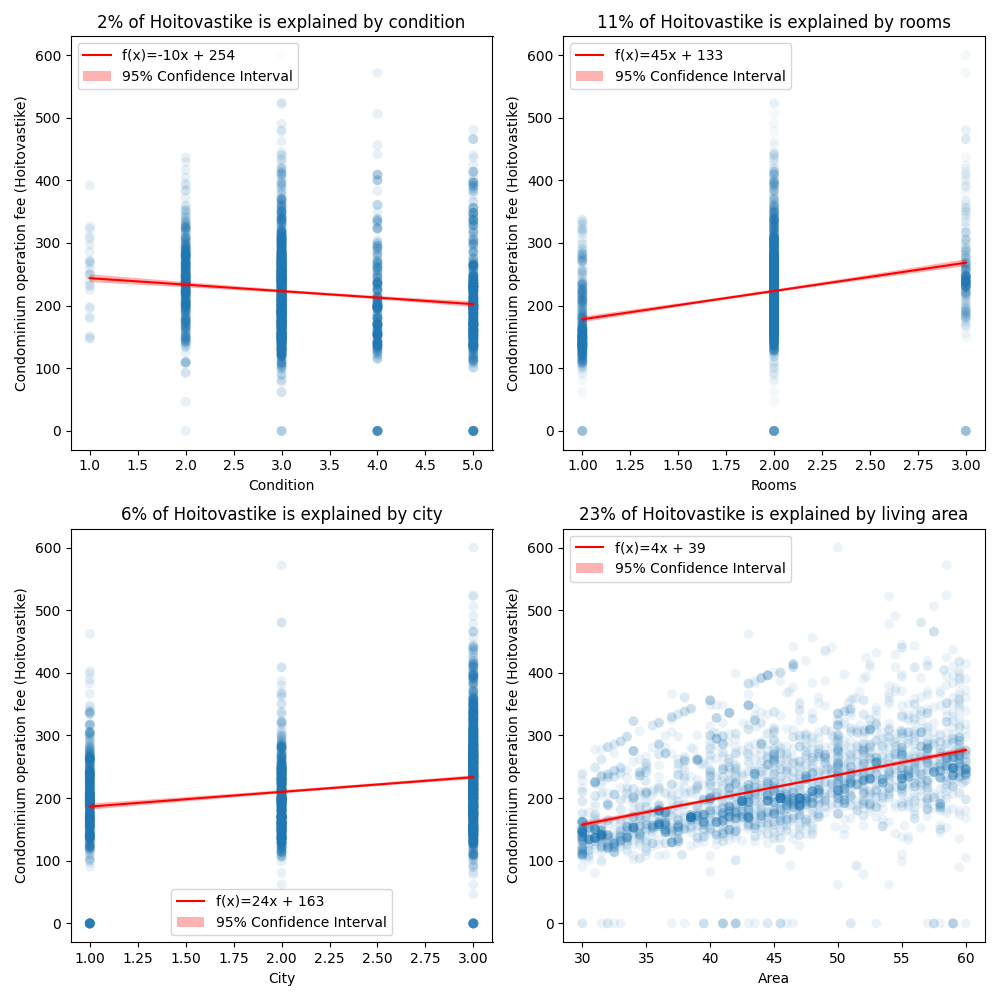

In [206]:
plt.figure('Condominium payment')
plt.clf()
plt.gcf().set_figheight(10)
plt.gcf().set_figwidth(10)

plt.subplot(2, 2, 1)
y = df.condominium_operation_fee
x = df.condition
plt.scatter(x, y, alpha=0.1, edgecolors='None', s=50)
mask = ~np.isnan(x) & ~np.isnan(y)
p = np.polyfit(x[mask],y[mask], 1)
x_reg = np.linspace(np.min(x), np.max(x), 50)
y_reg = np.polyval(p, x_reg)
plt.plot(x_reg, y_reg, color='r', label=f'f(x)={p[0]:.0f}x + {p[1]:.0f}')
ci, r2 = compute_regression_ci(p, x_reg, x, y)
plt.fill_between(x_reg, y_reg+ci, y_reg-ci, color='r', alpha=0.3, edgecolor='None', label='95% Confidence Interval')

plt.legend(loc='best')
plt.xlabel('Condition')
plt.ylabel('Condominium operation fee (Hoitovastike)')
plt.title(f'{r2:.0f}% of Hoitovastike is explained by condition')


plt.subplot(2, 2, 2)
y = df.condominium_operation_fee	
x = df.rooms
plt.scatter(x, y, alpha=0.05, edgecolors='None', s=50)
mask = ~np.isnan(x) & ~np.isnan(y)
p = np.polyfit(x[mask],y[mask], 1)
x_reg = np.linspace(np.min(x), np.max(x), 50)
y_reg = np.polyval(p, x_reg)
plt.plot(x_reg, y_reg, color='r', label=f'f(x)={p[0]:.0f}x + {p[1]:.0f}')
ci, r2 = compute_regression_ci(p, x_reg, x, y)
plt.fill_between(x_reg, y_reg+ci, y_reg-ci, color='r', alpha=0.3, edgecolor='None', label='95% Confidence Interval')

plt.legend(loc='best')
plt.xlabel('Rooms')
plt.ylabel('Condominium operation fee (Hoitovastike)')
plt.title(f'{r2:.0f}% of Hoitovastike is explained by rooms')

plt.subplot(2, 2, 3)
y = df.condominium_operation_fee	
x = df.city
plt.scatter(x, y, alpha=0.1, edgecolors='None', s=50)
mask = ~np.isnan(x) & ~np.isnan(y)
p = np.polyfit(x[mask],y[mask], 1)
x_reg = np.linspace(np.min(x), np.max(x), 50)
y_reg = np.polyval(p, x_reg)
plt.plot(x_reg, y_reg, color='r', label=f'f(x)={p[0]:.0f}x + {p[1]:.0f}')
ci, r2 = compute_regression_ci(p, x_reg, x, y)
plt.fill_between(x_reg, y_reg+ci, y_reg-ci, color='r', alpha=0.3, edgecolor='None', label='95% Confidence Interval')

plt.legend(loc='best')
plt.xlabel('City')
plt.ylabel('Condominium operation fee (Hoitovastike)')
plt.title(f'{r2:.0f}% of Hoitovastike is explained by city')

plt.subplot(2, 2, 4)
y = df.condominium_operation_fee	
x = df.area
plt.scatter(x, y, alpha=0.08, edgecolors='None', s=50)
mask = ~np.isnan(x) & ~np.isnan(y)
p = np.polyfit(x[mask],y[mask], 1)
x_reg = np.linspace(np.min(x), np.max(x), 50)
y_reg = np.polyval(p, x_reg)
plt.plot(x_reg, y_reg, color='r', label=f'f(x)={p[0]:.0f}x + {p[1]:.0f}')
ci, r2 = compute_regression_ci(p, x_reg, x, y)
plt.fill_between(x_reg, y_reg+ci, y_reg-ci, color='r', alpha=0.3, edgecolor='None', label='95% Confidence Interval')

plt.legend(loc='best')
plt.xlabel('Area')
plt.ylabel('Condominium operation fee (Hoitovastike)')
plt.title(f'{r2:.0f}% of Hoitovastike is explained by living area')

plt.tight_layout()
plt.show()

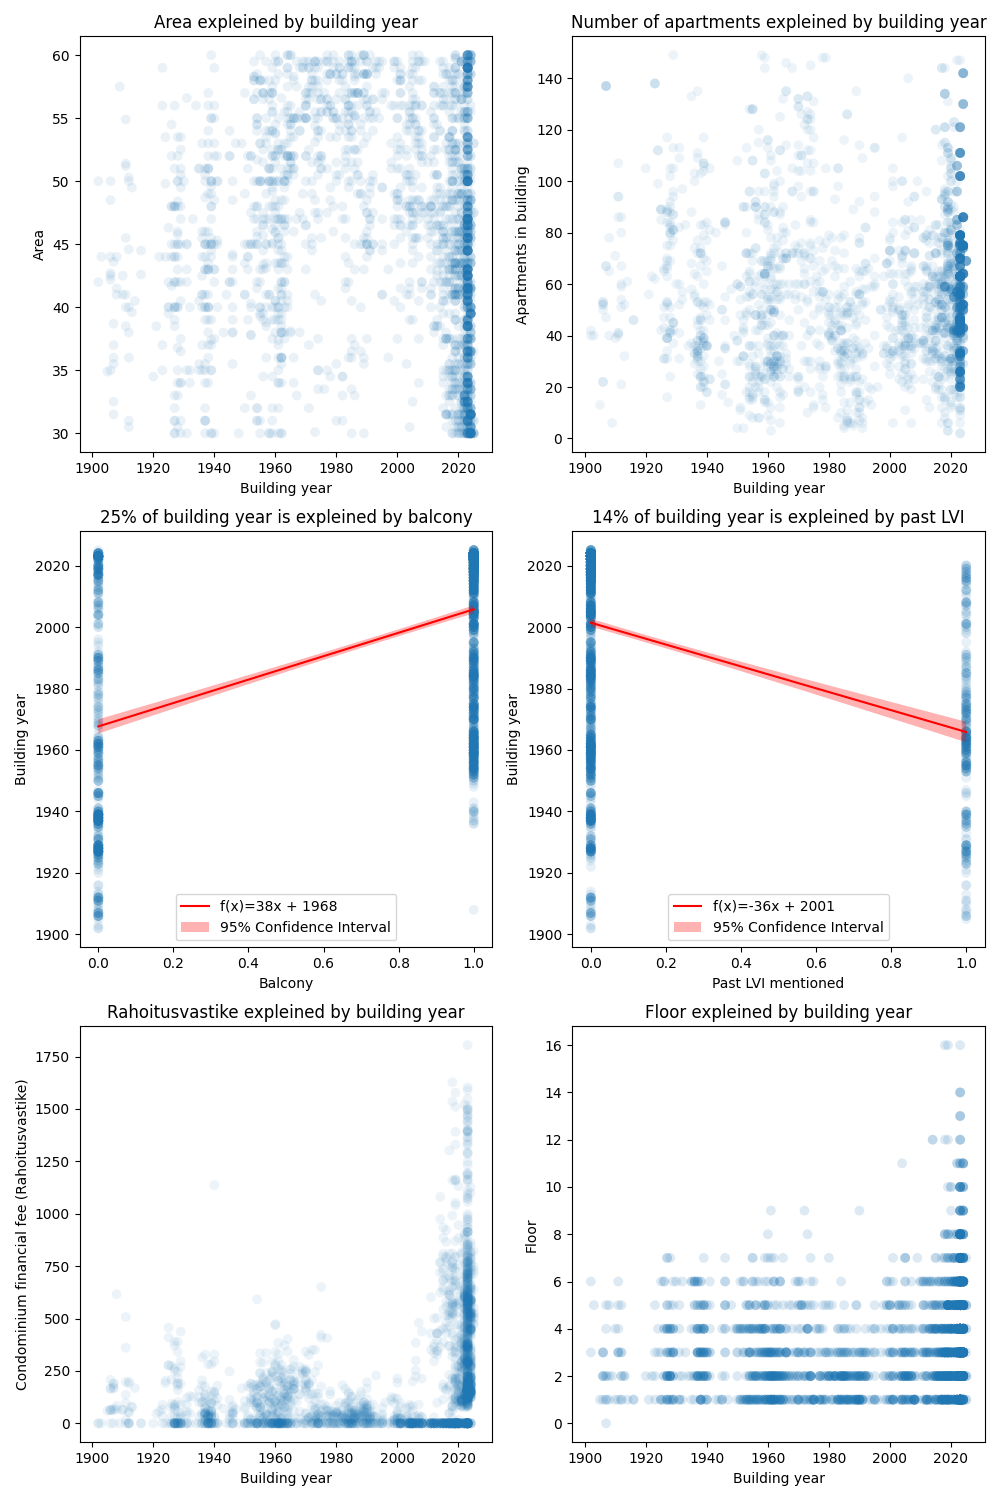

In [213]:
df_plot = df.loc[df['building_year'] > 1900]
df_plot = df_plot.loc[df_plot['apartments_in_building'] < 150]

plt.figure('Year')
plt.clf()
plt.gcf().set_figheight(15)
plt.gcf().set_figwidth(10)

plt.subplot(3, 2, 1)
y = df_plot.area
x = df_plot.building_year
plt.scatter(x, y, alpha=0.09, edgecolors='None', s=50)
'''
mask = ~np.isnan(x) & ~np.isnan(y)
p = np.polyfit(x[mask],y[mask], 1)
x_reg = np.linspace(np.min(x), np.max(x), 50)
y_reg = np.polyval(p, x_reg)
plt.plot(x_reg, y_reg, color='r', label=f'f(x)={p[0]:.2f}x + {y_reg[0]:.1f}')
ci, r2 = compute_regression_ci(p, x_reg, x, y)
plt.fill_between(x_reg, y_reg+ci, y_reg-ci, color='r', alpha=0.3, edgecolor='None', label='95% Confidence Interval')

plt.legend(loc='best')
'''
plt.xlabel('Building year')
plt.ylabel('Area')
plt.title(f'Area expleined by building year')


plt.subplot(3, 2, 2)
y = df_plot.apartments_in_building
x = df_plot.building_year
plt.scatter(x, y, alpha=0.08, edgecolors='None', s=50)
'''
mask = ~np.isnan(x) & ~np.isnan(y)
p = np.polyfit(x[mask],y[mask], 1)
x_reg = np.linspace(np.min(x), np.max(x), 50)
y_reg = np.polyval(p, x_reg)
plt.plot(x_reg, y_reg, color='r', label=f'f(x)={p[0]:.1f}x + {y_reg[0]:.1f}')
ci, r2 = compute_regression_ci(p, x_reg, x, y)
plt.fill_between(x_reg, y_reg+ci, y_reg-ci, color='r', alpha=0.3, edgecolor='None', label='95% Confidence Interval')

plt.legend(loc='best')
'''
plt.xlabel('Building year')
plt.ylabel('Apartments in building')
plt.title(f'Number of apartments expleined by building year')


plt.subplot(3, 2, 3)
x = df_plot.balcony
y = df_plot.building_year
plt.scatter(x, y, alpha=0.1, edgecolors='None', s=50)
mask = ~np.isnan(x) & ~np.isnan(y)
p = np.polyfit(x[mask],y[mask], 1)
x_reg = np.linspace(np.min(x), np.max(x), 50)
y_reg = np.polyval(p, x_reg)
plt.plot(x_reg, y_reg, color='r', label=f'f(x)={p[0]:.0f}x + {y_reg[0]:.0f}')
ci, r2 = compute_regression_ci(p, x_reg, x, y)
plt.fill_between(x_reg, y_reg+ci, y_reg-ci, color='r', alpha=0.3, edgecolor='None', label='95% Confidence Interval')

plt.legend(loc='best')
plt.ylabel('Building year')
plt.xlabel('Balcony')
plt.title(f'{r2:.0f}% of building year is expleined by balcony')


plt.subplot(3, 2, 4)
x = df_plot.lvi_past
y = df_plot.building_year
plt.scatter(x, y, alpha=0.1, edgecolors='None', s=50)
mask = ~np.isnan(x) & ~np.isnan(y)
p = np.polyfit(x[mask],y[mask], 1)
x_reg = np.linspace(np.min(x), np.max(x), 50)
y_reg = np.polyval(p, x_reg)
plt.plot(x_reg, y_reg, color='r', label=f'f(x)={p[0]:.0f}x + {y_reg[0]:.0f}')
ci, r2 = compute_regression_ci(p, x_reg, x, y)
plt.fill_between(x_reg, y_reg+ci, y_reg-ci, color='r', alpha=0.3, edgecolor='None', label='95% Confidence Interval')

plt.legend(loc='best')
plt.ylabel('Building year')
plt.xlabel('Past LVI mentioned')
plt.title(f'{r2:.0f}% of building year is expleined by past LVI')



plt.subplot(3, 2, 5)
y = df_plot.condominium_financial_fee
x = df_plot.building_year
plt.scatter(x, y, alpha=0.08, edgecolors='None', s=50)
'''
mask = ~np.isnan(x) & ~np.isnan(y)
x_reg = np.linspace(np.min(x), np.max(x), len(x))
def exp(x, a, b, c):
    return np.exp(a * (x - b)) + c
p0 = [4, 2000, 100]
popt, pcov = curve_fit(exp, x[mask], y[mask], p0)
a, b, c= popt
y_fitted = exp(x_reg, a, b, c)
plt.plot(x_reg, y_fitted, color='r', label=f'$e^({a:.1f}(x-{b:.1f})+{c:.1f}$')
'''

plt.xlabel('Building year')
plt.ylabel('Condominium financial fee (Rahoitusvastike)')
plt.title(f'Rahoitusvastike expleined by building year')


plt.subplot(3, 2, 6)
y = df_plot.floor	
x = df_plot.building_year
plt.scatter(x, y, alpha=0.15, edgecolors='None', s=50)
'''
mask = ~np.isnan(x) & ~np.isnan(y)
x_reg = np.linspace(np.min(x), np.max(x), len(x))
def exp(x, a, b, c):
    return np.exp(a * (x - b)) + c
p0 = [4, 2000, 100]
popt, pcov = curve_fit(exp, x[mask], y[mask], p0)
a, b, c= popt
y_fitted = exp(x_reg, a, b, c)
plt.plot(x_reg, y_fitted, color='r', label=f'$e^({a:.1f}(x-{b:.1f})+{c:.1f}$')
'''

plt.xlabel('Building year')
plt.ylabel('Floor')
plt.title(f'Floor expleined by building year')



plt.tight_layout()
plt.show()

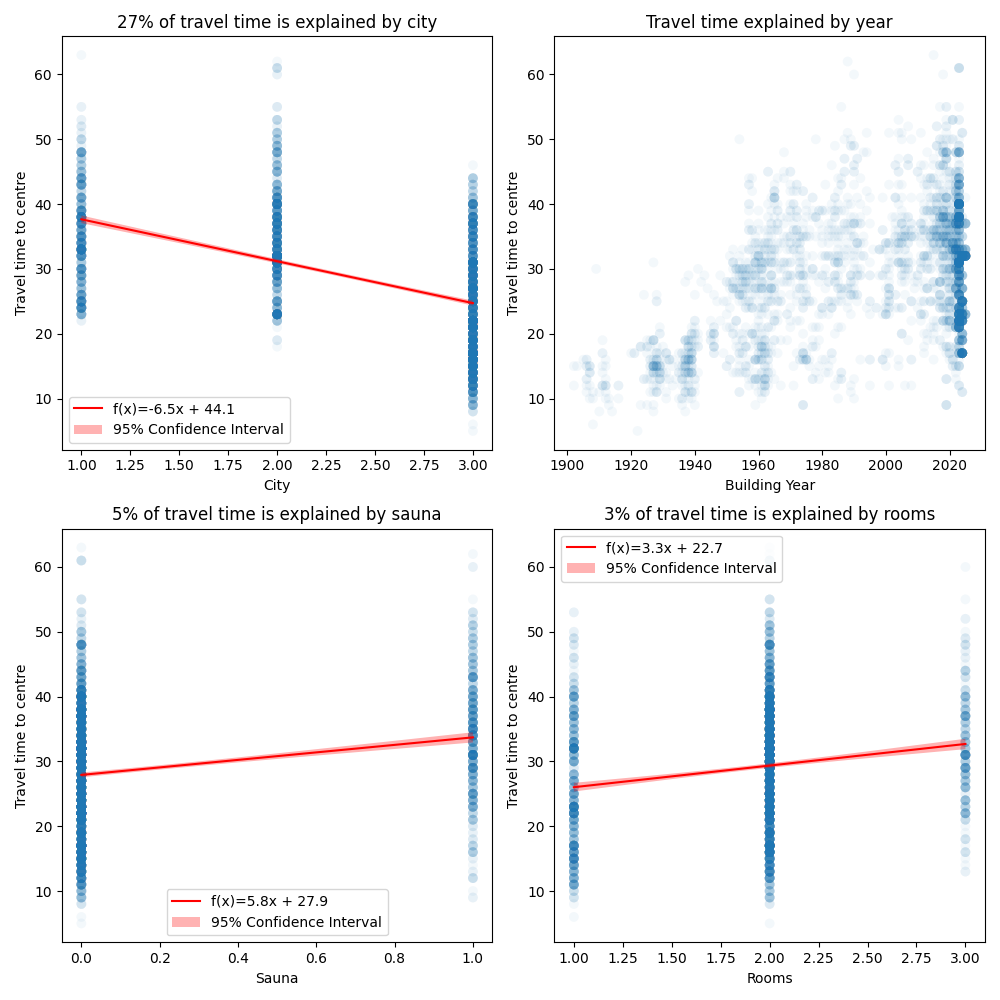

In [7]:
df_plot = df.loc[df['building_year'] > 1900]

plt.figure('Travel time')
plt.clf()
plt.gcf().set_figheight(10)
plt.gcf().set_figwidth(10)

plt.subplot(2, 2, 1)
y = df_plot.travel_time
x = df_plot.city
plt.scatter(x, y, alpha=0.05, edgecolors='None', s=50)
mask = ~np.isnan(x) & ~np.isnan(y)
p = np.polyfit(x[mask],y[mask], 1)
x_reg = np.linspace(np.min(x), np.max(x), 50)
y_reg = np.polyval(p, x_reg)
plt.plot(x_reg, y_reg, color='r', label=f'f(x)={p[0]:.1f}x + {p[1]:.1f}')
ci, r2 = compute_regression_ci(p, x_reg, x, y)
plt.fill_between(x_reg, y_reg+ci, y_reg-ci, color='r', alpha=0.3, edgecolor='None', label='95% Confidence Interval')

plt.legend(loc='best')
plt.xlabel('City')
plt.ylabel('Travel time to centre')
plt.title(f'{r2:.0f}% of travel time is explained by city') 


plt.subplot(2, 2, 2)
y = df_plot.travel_time
x = df_plot.building_year
plt.scatter(x, y, alpha=0.05, edgecolors='None', s=50)
'''
mask = ~np.isnan(x) & ~np.isnan(y)
p = np.polyfit(x[mask],y[mask], 1)
x_reg = np.linspace(np.min(x), np.max(x), 50)
y_reg = np.polyval(p, x_reg)
plt.plot(x_reg, y_reg, color='r', label=f'f(x)={p[0]:.1f}x + {y_reg[0]:.1f}')
ci, r2 = compute_regression_ci(p, x_reg, x, y)
plt.fill_between(x_reg, y_reg+ci, y_reg-ci, color='r', alpha=0.3, edgecolor='None', label='95% Confidence Interval')

plt.legend(loc='best')
'''
plt.xlabel('Building Year')
plt.ylabel('Travel time to centre')
plt.title(f'Travel time explained by year')


plt.subplot(2, 2, 3)
y = df_plot.travel_time
x = df_plot.sauna
plt.scatter(x, y, alpha=0.05, edgecolors='None', s=50)
mask = ~np.isnan(x) & ~np.isnan(y)
p = np.polyfit(x[mask],y[mask], 1)
x_reg = np.linspace(np.min(x), np.max(x), 50)
y_reg = np.polyval(p, x_reg)
plt.plot(x_reg, y_reg, color='r', label=f'f(x)={p[0]:.1f}x + {p[1]:.1f}')
ci, r2 = compute_regression_ci(p, x_reg, x, y)
plt.fill_between(x_reg, y_reg+ci, y_reg-ci, color='r', alpha=0.3, edgecolor='None', label='95% Confidence Interval')

plt.legend(loc='best')
plt.xlabel('Sauna')
plt.ylabel('Travel time to centre')
plt.title(f'{r2:.0f}% of travel time is explained by sauna')


plt.subplot(2, 2, 4)
y = df_plot.travel_time
x = df_plot.rooms
plt.scatter(x, y, alpha=0.05, edgecolors='None', s=50)
mask = ~np.isnan(x) & ~np.isnan(y)
p = np.polyfit(x[mask],y[mask], 1)
x_reg = np.linspace(np.min(x), np.max(x), 50)
y_reg = np.polyval(p, x_reg)
plt.plot(x_reg, y_reg, color='r', label=f'f(x)={p[0]:.1f}x + {p[1]:.1f}')
ci, r2 = compute_regression_ci(p, x_reg, x, y)
plt.fill_between(x_reg, y_reg+ci, y_reg-ci, color='r', alpha=0.3, edgecolor='None', label='95% Confidence Interval')

plt.legend(loc='best')
plt.xlabel('Rooms')
plt.ylabel('Travel time to centre')
plt.title(f'{r2:.0f}% of travel time is explained by rooms')



plt.tight_layout()
plt.show()

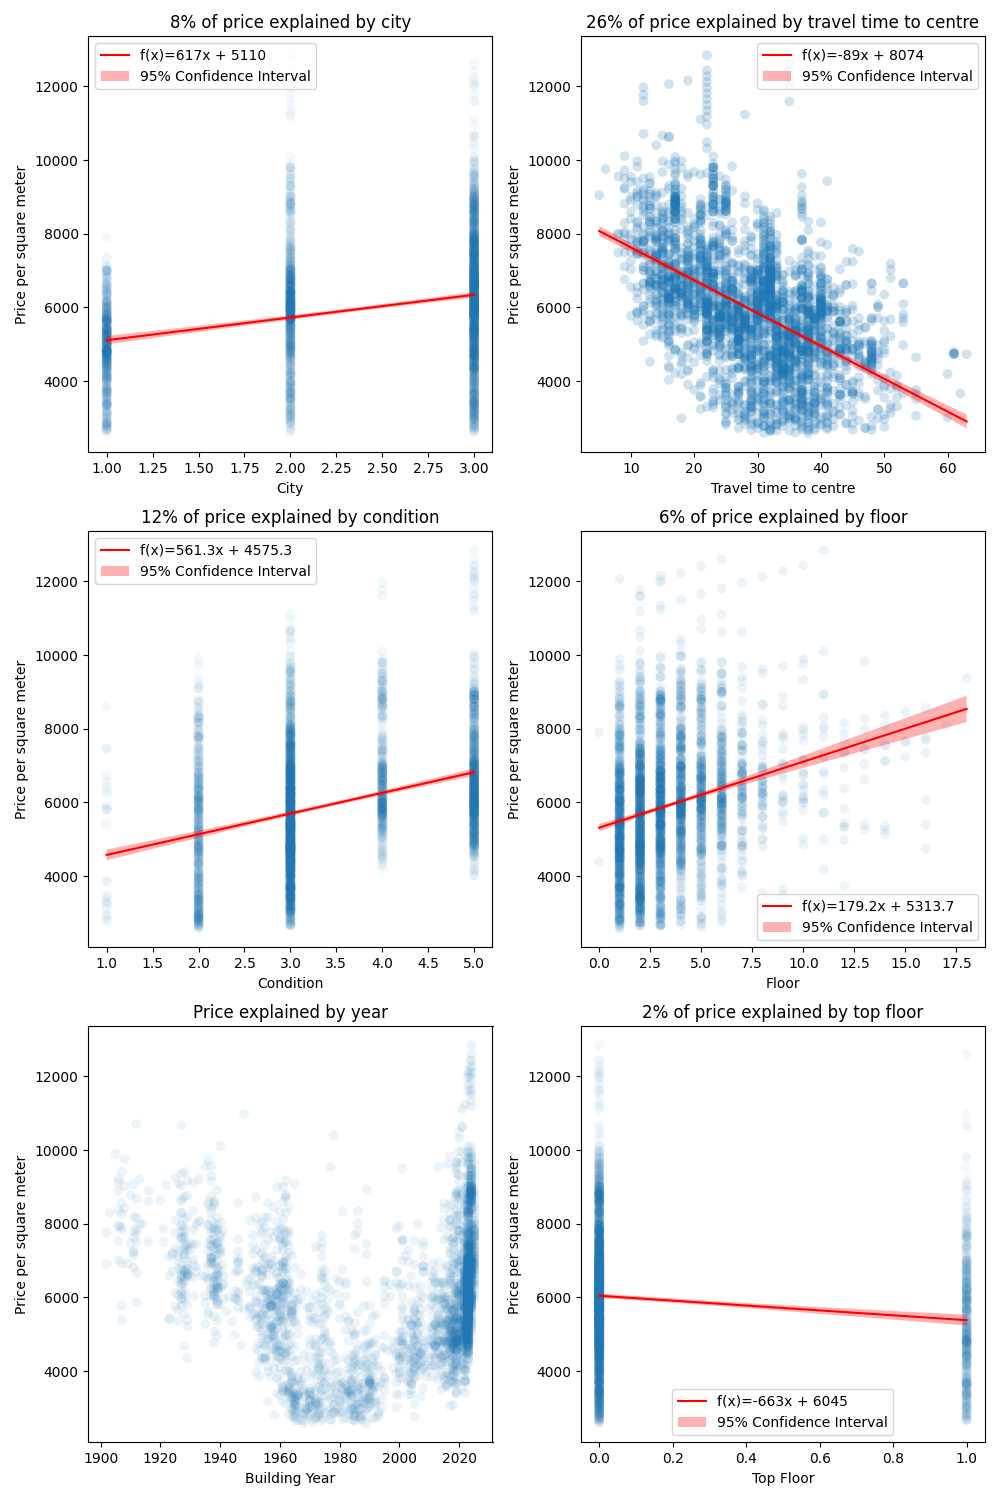

In [16]:
df_plot = df.loc[df['building_year'] > 1900].copy()
df_plot.price = df_plot.price / df_plot.area

plt.figure('Price')
plt.clf()
plt.gcf().set_figheight(15)
plt.gcf().set_figwidth(10)

plt.subplot(3, 2, 1)
y = df_plot.price
x = df_plot.city
plt.scatter(x, y, alpha=0.04, edgecolors='None', s=50)
mask = ~np.isnan(x) & ~np.isnan(y)
p = np.polyfit(x[mask],y[mask], 1)
x_reg = np.linspace(np.min(x), np.max(x), 50)
y_reg = np.polyval(p, x_reg)
plt.plot(x_reg, y_reg, color='r', label=f'f(x)={p[0]:.0f}x + {y_reg[0]:.0f}')
ci, r2 = compute_regression_ci(p, x_reg, x, y)
plt.fill_between(x_reg, y_reg+ci, y_reg-ci, color='r', alpha=0.3, edgecolor='None', label='95% Confidence Interval')

plt.legend(loc='best')
plt.xlabel('City')
plt.ylabel('Price per square meter')
plt.title(f'{r2:.0f}% of price explained by city')


plt.subplot(3, 2, 2)
y = df_plot.price
x = df_plot.travel_time
plt.scatter(x, y, alpha=0.2, edgecolors='None', s=50)
mask = ~np.isnan(x) & ~np.isnan(y)
p = np.polyfit(x[mask],y[mask], 1)
x_reg = np.linspace(np.min(x), np.max(x), 50)
y_reg = np.polyval(p, x_reg)
plt.plot(x_reg, y_reg, color='r', label=f'f(x)={p[0]:.0f}x + {y_reg[0]:.0f}')
ci, r2 = compute_regression_ci(p, x_reg, x, y)
plt.fill_between(x_reg, y_reg+ci, y_reg-ci, color='r', alpha=0.3, edgecolor='None', label='95% Confidence Interval')

plt.legend(loc='best')
plt.xlabel('Travel time to centre')
plt.ylabel('Price per square meter')
plt.title(f'{r2:.0f}% of price explained by travel time to centre')


plt.subplot(3, 2, 3)
y = df_plot.price
x = df_plot.condition
plt.scatter(x, y, alpha=0.05, edgecolors='None', s=50)
mask = ~np.isnan(x) & ~np.isnan(y)
p = np.polyfit(x[mask],y[mask], 1)
x_reg = np.linspace(np.min(x), np.max(x), 50)
y_reg = np.polyval(p, x_reg)
plt.plot(x_reg, y_reg, color='r', label=f'f(x)={p[0]:.1f}x + {y_reg[0]:.1f}')
ci, r2 = compute_regression_ci(p, x_reg, x, y)
plt.fill_between(x_reg, y_reg+ci, y_reg-ci, color='r', alpha=0.3, edgecolor='None', label='95% Confidence Interval')

plt.legend(loc='best')
plt.xlabel('Condition')
plt.ylabel('Price per square meter')
plt.title(f'{r2:.0f}% of price explained by condition')


plt.subplot(3, 2, 4)
y = df_plot.price
x = df_plot.floor
plt.scatter(x, y, alpha=0.08, edgecolors='None', s=50)
mask = ~np.isnan(x) & ~np.isnan(y)
p = np.polyfit(x[mask],y[mask], 1)
x_reg = np.linspace(np.min(x), np.max(x), 50)
y_reg = np.polyval(p, x_reg)
plt.plot(x_reg, y_reg, color='r', label=f'f(x)={p[0]:.1f}x + {y_reg[0]:.1f}')
ci, r2 = compute_regression_ci(p, x_reg, x, y)
plt.fill_between(x_reg, y_reg+ci, y_reg-ci, color='r', alpha=0.3, edgecolor='None', label='95% Confidence Interval')

plt.legend(loc='best')
plt.xlabel('Floor')
plt.ylabel('Price per square meter')
plt.title(f'{r2:.0f}% of price explained by floor')


plt.subplot(3, 2, 5)
y = df_plot.price
x = df_plot.building_year
plt.scatter(x, y, alpha=0.08, edgecolors='None', s=50)
'''
mask = ~np.isnan(x) & ~np.isnan(y)
p = np.polyfit(x[mask],y[mask], 1)
x_reg = np.linspace(np.min(x), np.max(x), 50)
y_reg = np.polyval(p, x_reg)
plt.plot(x_reg, y_reg, color='r', label=f'f(x)={p[0]:.1f}x + {y_reg[0]:.1f}')
ci, r2 = compute_regression_ci(p, x_reg, x, y)
plt.fill_between(x_reg, y_reg+ci, y_reg-ci, color='r', alpha=0.3, edgecolor='None', label='95% Confidence Interval')

plt.legend(loc='best')
'''
plt.xlabel('Building Year')
plt.ylabel('Price per square meter')
plt.title(f'Price explained by year')


plt.subplot(3, 2, 6)
y = df_plot.price
x = df_plot.top_floor
plt.scatter(x, y, alpha=0.04, edgecolors='None', s=50)
mask = ~np.isnan(x) & ~np.isnan(y)
p = np.polyfit(x[mask],y[mask], 1)
x_reg = np.linspace(np.min(x), np.max(x), 50)
y_reg = np.polyval(p, x_reg)
plt.plot(x_reg, y_reg, color='r', label=f'f(x)={p[0]:.0f}x + {y_reg[0]:.0f}')
ci, r2 = compute_regression_ci(p, x_reg, x, y)
plt.fill_between(x_reg, y_reg+ci, y_reg-ci, color='r', alpha=0.3, edgecolor='None', label='95% Confidence Interval')

plt.legend(loc='best')
plt.xlabel('Top Floor')
plt.ylabel('Price per square meter')
plt.title(f'{r2:.0f}% of price explained by top floor')


plt.tight_layout()
plt.show()

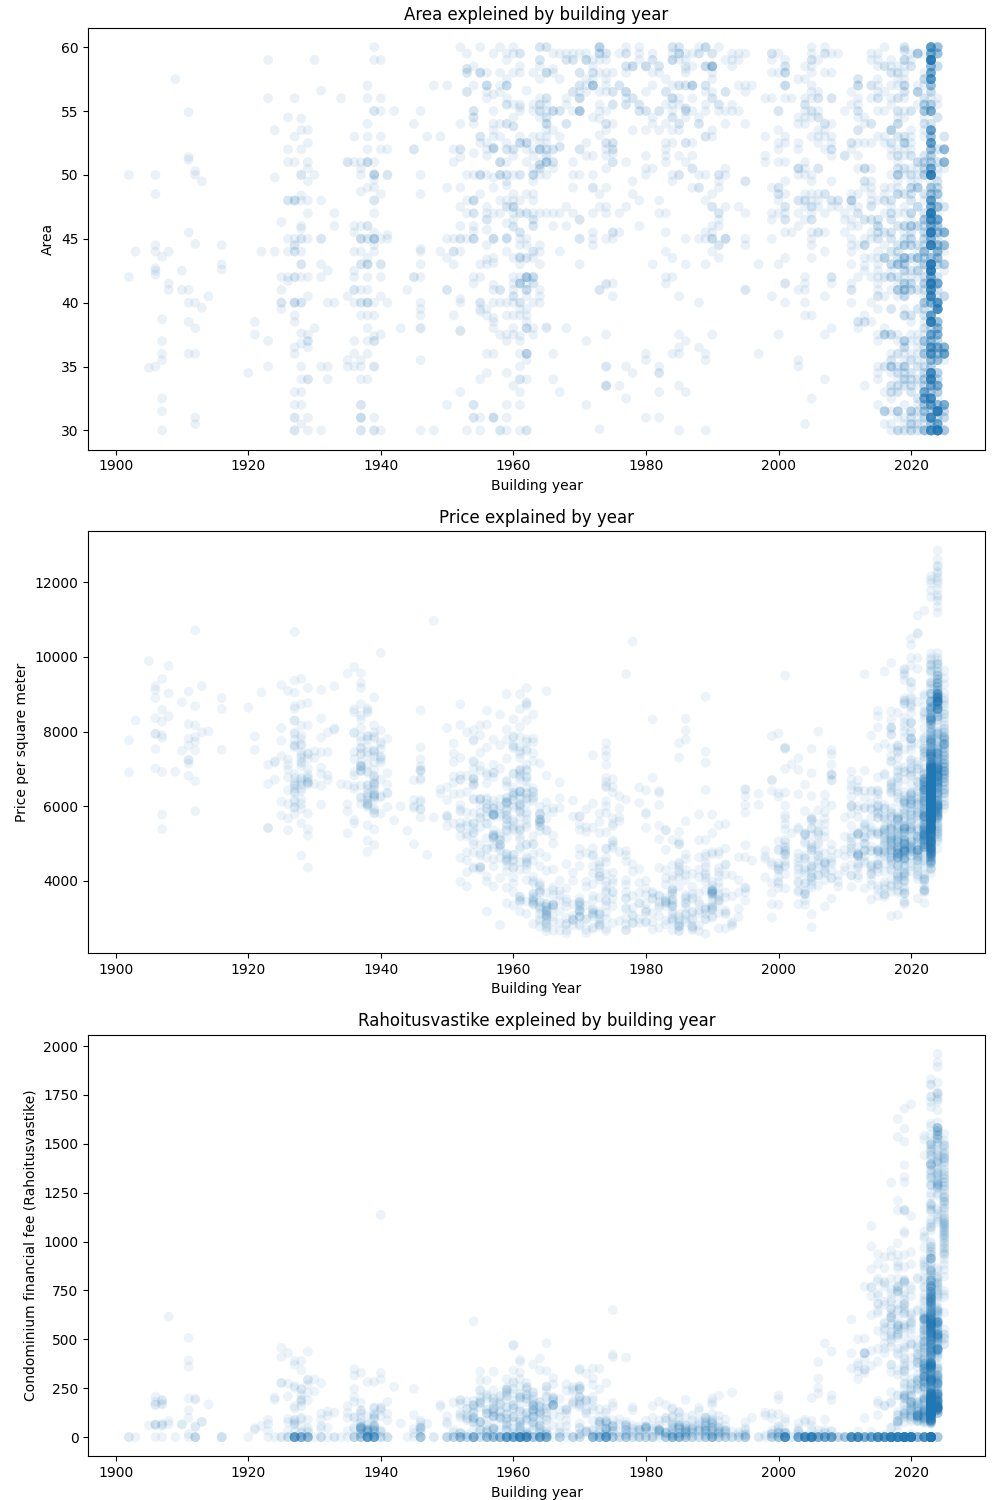

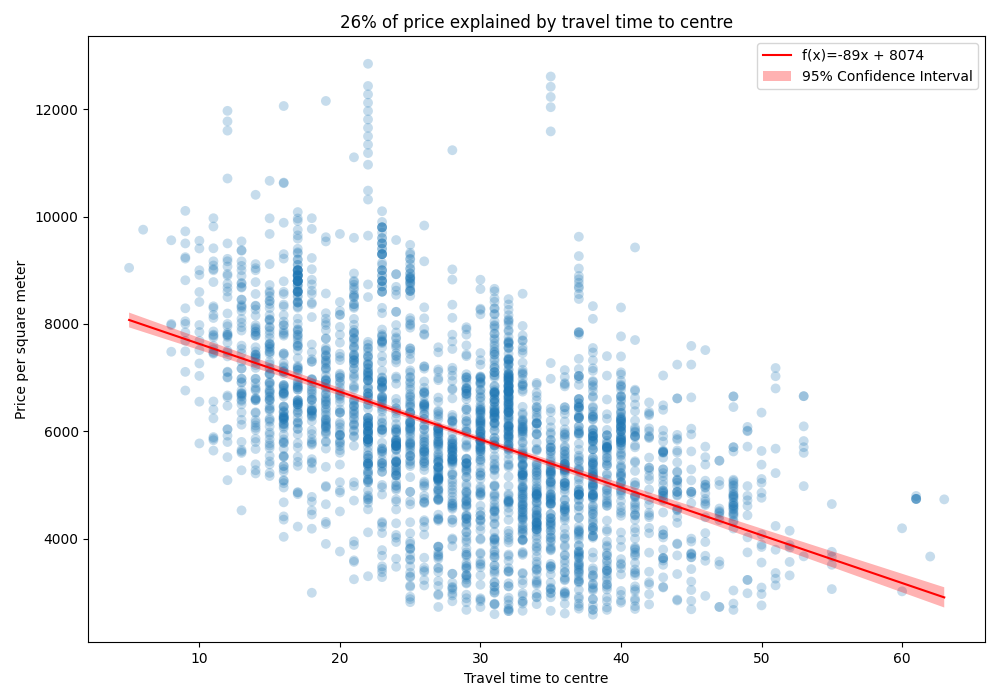

In [22]:
df_plot = df.loc[df['building_year'] > 1900].copy()
df_plot.price = df_plot.price / df_plot.area

plt.figure('Main plots')
plt.clf()
plt.gcf().set_figheight(15)
plt.gcf().set_figwidth(10)


plt.subplot(3, 1, 1)
y = df_plot.area
x = df_plot.building_year
plt.scatter(x, y, alpha=0.09, edgecolors='None', s=50)
plt.xlabel('Building year')
plt.ylabel('Area')
plt.title(f'Area expleined by building year')


plt.subplot(3, 1, 2)
y = df_plot.price
x = df_plot.building_year
plt.scatter(x, y, alpha=0.08, edgecolors='None', s=50)
plt.xlabel('Building Year')
plt.ylabel('Price per square meter')
plt.title(f'Price explained by year')



plt.subplot(3, 1, 3)
y = df_plot.condominium_financial_fee
x = df_plot.building_year
plt.scatter(x, y, alpha=0.08, edgecolors='None', s=50)
plt.xlabel('Building year')
plt.ylabel('Condominium financial fee (Rahoitusvastike)')
plt.title(f'Rahoitusvastike expleined by building year')

plt.show()


plt.figure('Time to price')
plt.clf()
plt.gcf().set_figheight(7)
plt.gcf().set_figwidth(10)

y = df_plot.price
x = df_plot.travel_time
plt.scatter(x, y, alpha=0.25, edgecolors='None', s=50)
mask = ~np.isnan(x) & ~np.isnan(y)
p = np.polyfit(x[mask],y[mask], 1)
x_reg = np.linspace(np.min(x), np.max(x), 50)
y_reg = np.polyval(p, x_reg)
plt.plot(x_reg, y_reg, color='r', label=f'f(x)={p[0]:.0f}x + {y_reg[0]:.0f}')
ci, r2 = compute_regression_ci(p, x_reg, x, y)
plt.fill_between(x_reg, y_reg+ci, y_reg-ci, color='r', alpha=0.3, edgecolor='None', label='95% Confidence Interval')
plt.legend(loc='best')
plt.xlabel('Travel time to centre')
plt.ylabel('Price per square meter')
plt.title(f'{r2:.0f}% of price explained by travel time to centre')

plt.tight_layout()

plt.show()